## Uncertainty in Explanations via Model Perturbation (Tabular)

Notebook derived from https://colab.research.google.com/drive/1pjDJmAa9oeSquYtbYh6tksU6eTmObIcq

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import time

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
from xplique.attributions import (Saliency,
                             IntegratedGradients,
                             KernelShap,
                             Lime,
                             Occlusion,
                             SmoothGrad,
                             VarGrad,
                             SquareGrad,
                             GuidedBackprop,
                             DeconvNet,
                             GradientInput)
from xplique.plots import plot_feature_impact, plot_mean_feature_impact, summary_plot_tabular

### Load dataset

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# the dataset contains na value, we just drop them
dataset = dataset.dropna()
# the origin column is not numeric so we convert it to a one hot-hot
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [7]:
# Splits
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

In [8]:
# Separate features from labels
train_features = train_dataset.copy()
test_features  = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels  = test_features.pop('MPG')

In [9]:
# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.values)
test_features  = scaler.transform(test_features.values)

In [10]:
inputs_tf, targets_tf = tf.cast(test_features, tf.float32), tf.cast(test_labels, tf.float32)
targets_tf = tf.expand_dims(targets_tf, axis=-1)
new_targets_tf = tf.ones((78,1))
len(targets_tf)

78

In [11]:
features_name = [
    'Cylinders',
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
    'Europe',
    'Japan',
    'USA'
]

### Train/Load Model

In [12]:
# Whether to train a model or load a pretrained one
train_model = False
model_path = './models/ann_tabular.h5'

In [13]:
if train_model:
    # Define a simple ANN
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    %%time
    history = model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=100)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)

### Explain Model

In [14]:
#explainer = SquareGrad(model)
#explainer = VarGrad(model)
#explainer = SmoothGrad(model)
explainer = Lime(model)
explanation = explainer(inputs_tf, new_targets_tf)

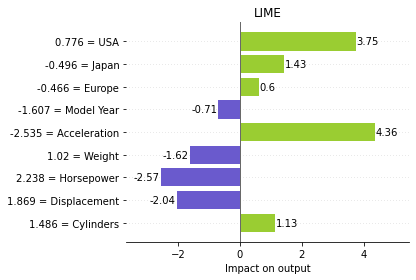

In [15]:
plot_feature_impact(explanation[0], features_name, test_features[0])
plt.title('LIME')
plt.show()

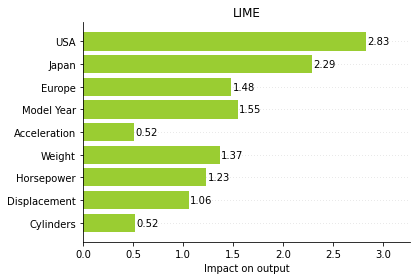

In [16]:
plot_mean_feature_impact(explanation, features_name)
plt.title('LIME')
plt.show()

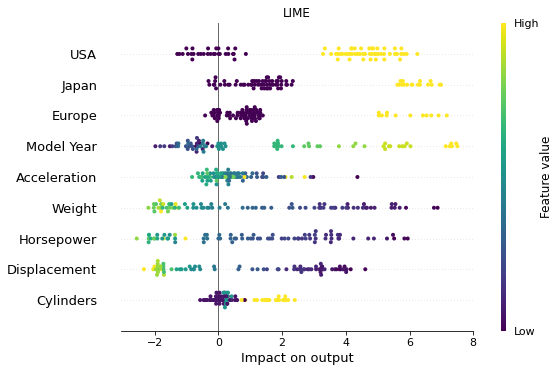

In [17]:
summary_plot_tabular(
    explanation,
    features_values=test_features,
    features_name=features_name
)
plt.title('LIME')
plt.show()

### Compute variance analytically

In [18]:
# Explain one sample
ex_ind = 0
ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)
ex_exp = explainer(ex_row, ex_target)

In [ ]:
# Compute derivative of explanation w.r.t model weights via FDM
dx = 1e-1
n = model.layers[-1].weights[0].shape[0] # number of weights in the final Dense layer (without bias)
m = ex_exp.shape[1]
derivative_e_w = np.zeros((m, n))

# For every weight perturbation, we get a new column in the Jacobian
for i in range(n):
    # Perturb current weight in the model
    perturbed_model = tf.keras.models.load_model(model_path)
    weights, bias = perturbed_model.layers[-1].get_weights()
    weights[i] += dx
    perturbed_model.layers[-1].set_weights([weights, bias])

    # Compute explanations for perturbed model
    explainer = Lime(perturbed_model)
    perturbed_exp = explainer(ex_row, ex_target)

    # Compute FDM
    derivative_e_w[:, i] = (perturbed_exp - ex_exp) / dx

In [23]:
ex_exp

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 1.092, -2.108, -2.636, -1.096,  4.429, -0.779,  1.023,  1.179,
         3.711]], dtype=float32)>

In [24]:
perturbed_exp

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 1.066, -2.384, -2.583, -1.557,  4.459, -0.872,  0.8  ,  0.987,
         3.923]], dtype=float32)>

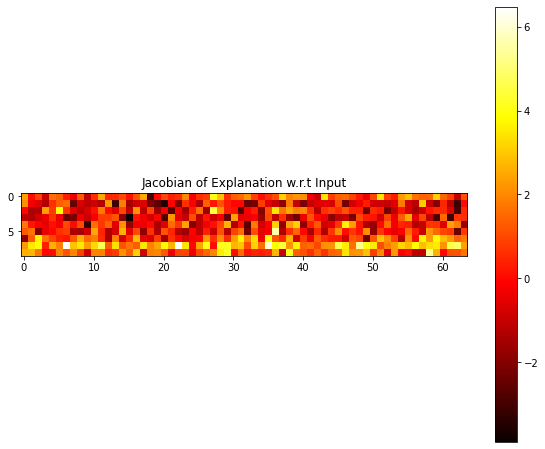

In [20]:
plt.figure(figsize=(10,8))
plt.imshow(derivative_e_w, cmap='hot')
plt.title("Jacobian of Explanation w.r.t Input")
plt.colorbar()
plt.show()

In [21]:
# Approximate covariance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * derivative_e_w @ derivative_e_w.T

# Total variance is the trace of the cov. matrix
print("Total Variance of Explanation (Analytical):", np.trace(variance_explanation))

Total Variance of Explanation (Analytical): 19.584987105300623


In [22]:
# Normalized total variance is the trace of the cov. matrix divided by the L2-norm of the unperturbed explanation
print("Normalized Variance of Explanation:", np.trace(variance_explanation) / np.linalg.norm(explanation))

Normalized Variance of Explanation: 0.2742984489594427


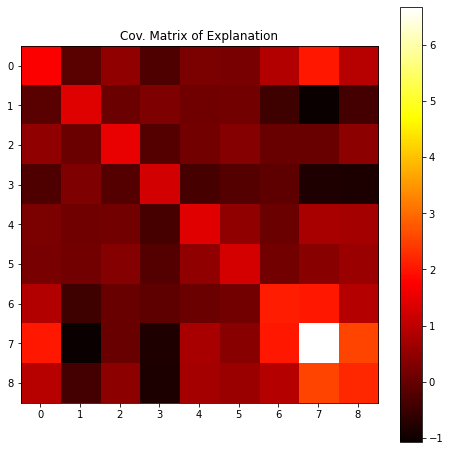

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(variance_explanation, cmap='hot')
plt.title("Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

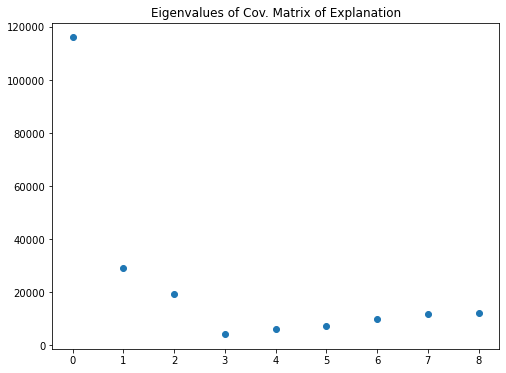

In [30]:
# Explained variance ratio
evals, evecs = np.linalg.eig(variance_explanation)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Cov. Matrix of Explanation');

### Compute variance empirically

In [32]:
num_perturbations = 10
perturbation_std = 0.1  # same as above for analytical formula
sigma_squared = perturbation_std ** 2

perturbed_explanations = []
for _ in range(num_perturbations):
    # Add Gaussian noise to the model weights
    perturbed_model = tf.keras.models.load_model(model_path)
    weights, bias = perturbed_model.layers[-1].get_weights()
    weights += np.random.normal(0, perturbation_std, weights.shape)
    perturbed_model.layers[-1].set_weights([weights, bias])

    # Compute explanations for perturbed rows
    explainer = Lime(perturbed_model)
    perturbed_explanations.append( explainer(ex_row, ex_target) )

# Stack explanations and compute covariance matrix
explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
empirical_covariance = np.cov(explanation_matrix, rowvar=False)

# Compute total variance (trace of the covariance matrix)
empirical_total_variance = np.trace(empirical_covariance)

print("Empirical Total Variance of Explanation:", empirical_total_variance)

Empirical Total Variance of Explanation: 0.4211186656802983


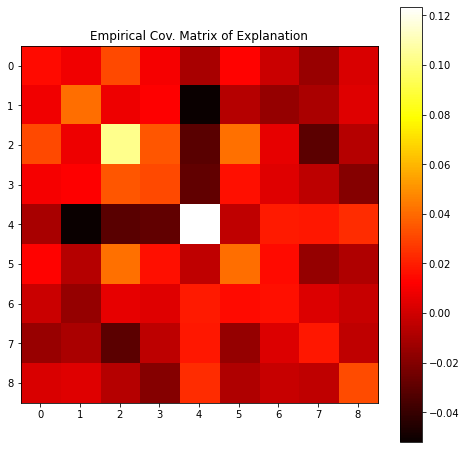

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(empirical_covariance, cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

### Analytical vs Empirical (multiple methods, multiple variances)

In [14]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # silence tf-function warnings
xai_methods  = {'Saliency': Saliency,
                #'GradientInput': GradientInput,
                #'IntegratedGradients': IntegratedGradients,
                'GuidedBackprop': GuidedBackprop,
                'Occlusion': lambda model: Occlusion(model, patch_size=1, patch_stride=1),
                #'KernelShap': KernelShap,
                #'Lime': Lime,
                }

In [15]:
#stds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5]
stds = [1e-5, 1e-2]
num_perturbations = 1000 #10 # for empirical cov.
dx = 1e-3 # differential for ana. cov.
n = model.layers[-1].weights[0].shape[0] # number of weights in the final Dense layer (without bias)
m = len(features_name)
# Note: 'n' in this notebook is 'r' in the paper

In [16]:
ex_inds = [0] #np.arange(10)
#results, jacobi_mats, empirical_exps, unperturbed_exps = {}, {}, {}, {}
empirical_exps, unperturbed_exps = {}, {}

# Load weights only once
weights, bias = model.layers[-1].get_weights()

start_time = time.time()
for ex_ind in ex_inds:
    # Sample to explain
    ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)
    
    # Store results for plotting
    #results[ex_ind]  = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
    #jacobi_mats[ex_ind] = {}
    empirical_exps[ex_ind] = {}
    unperturbed_exps[ex_ind] = {}

    print('\n*********')
    print('Sample ' + str(ex_ind))
    for name, constructor in xai_methods.items():
        print('\n' + name)
        empirical_exps[ex_ind][name] = {}
        
        # Get explanation in unperturbed model
        explainer = constructor(model) # instantiate explainer with default params
        explanation = explainer(ex_row, ex_target) # sample explanation
        unperturbed_exps[ex_ind][name] = explanation
        """
        # Norm of explanation (for normalization of total variance)
        norm_exp_squared = np.linalg.norm(explanation)**2
        
        # Precompute Jacobian (stays fixed for every std)
        derivative_e_w = np.zeros((m, n))
        # For every feature perturbation, we get a new column in the Jacobian
        for i in range(n):
            # Perturb current weight in the model
            perturbed_weights = np.copy(weights)
            perturbed_weights[i] += dx
            model.layers[-1].set_weights([perturbed_weights, bias])
    
            # Compute explanations for perturbed model
            explainer = constructor(model)
            perturbed_exp = explainer(ex_row, ex_target)
    
            # Compute FDM
            derivative_e_w[:, i] = (perturbed_exp - explanation) / dx
            
            # Restore unperturbed weights in model
            model.layers[-1].set_weights([weights, bias])
        jacobi_mats[ex_ind][name] = derivative_e_w
        
        jjt = derivative_e_w @ derivative_e_w.T # Compute jacobian product only once
        """
        for std in stds:
            ### Analytical
            """
            sigma_squared = std ** 2
            covariance_ana = sigma_squared * jjt
            
            # Total variance is the trace of the cov. matrix
            total_var = np.trace(covariance_ana)/norm_exp_squared
            print("Analytical Variance (std = ", std, "):", total_var)
            results[ex_ind][name]['analytical'].append(total_var)
            """
            ### Empirical
            perturbed_explanations = []
            for i in range(num_perturbations):
                if i%100 == 0: print(i)
                # Add Gaussian noise to the model weights   
                perturbed_weights = np.copy(weights)
                perturbed_weights += np.random.normal(0, std, weights.shape)
                model.layers[-1].set_weights([perturbed_weights, bias])
    
                # Compute explanations for perturbed rows
                explainer = constructor(model)
                perturbed_explanations.append( explainer(ex_row, ex_target) )
                
                # Restore unperturbed weights in model
                model.layers[-1].set_weights([weights, bias])
            
            # Stack explanations and compute covariance matrix
            explanation_matrix = np.stack(perturbed_explanations, axis=0)
            #covariance_emp = np.cov(explanation_matrix.squeeze(), rowvar=False)
            
            #total_var = np.trace(covariance_emp)/norm_exp_squared
            #print("Empirical Variance (std = ", std, "):", total_var)
            #results[ex_ind][name]['empirical'].append(total_var)

            # Store explanations for cov_emp and normality checks
            empirical_exps[ex_ind][name][std] = np.stack(perturbed_explanations, axis=0)
print("--- %s minutes ---" % ((time.time() - start_time)/60.0))


*********
Sample 0

Saliency
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900

GuidedBackprop
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900

Occlusion
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
--- 6.370353309313456 minutes ---


In [18]:
import pickle
experiments = {'results': results, 
               'jacobi_mats': jacobi_mats,
               'empirical_exps': empirical_exps, 
               'unperturbed_exps': unperturbed_exps}

with open('./experiments/experiments_weights_tabular_10ex_10pert_definitely_final.pickle', 'wb') as handle:
    pickle.dump(experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
#with open('./experiments/experiments_weights_tabular_1ex_100pert.pickle', 'rb') as handle:
#    experiments = pickle.load(handle)
#results = experiments['results']
#jacobi_mats = experiments['jacobi_mats']
#empirical_exps = experiments['empirical_exps']
#unperturbed_exps = experiments['unperturbed_exps']

In [17]:
# Results for distributions
experiments = {'empirical_exps': empirical_exps, 
               'unperturbed_exps': unperturbed_exps}

with open('./experiments/experiments_weights_tabular_1ex_1000pert_definitely_final.pickle', 'wb') as handle:
    pickle.dump(experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'pickle' is not defined

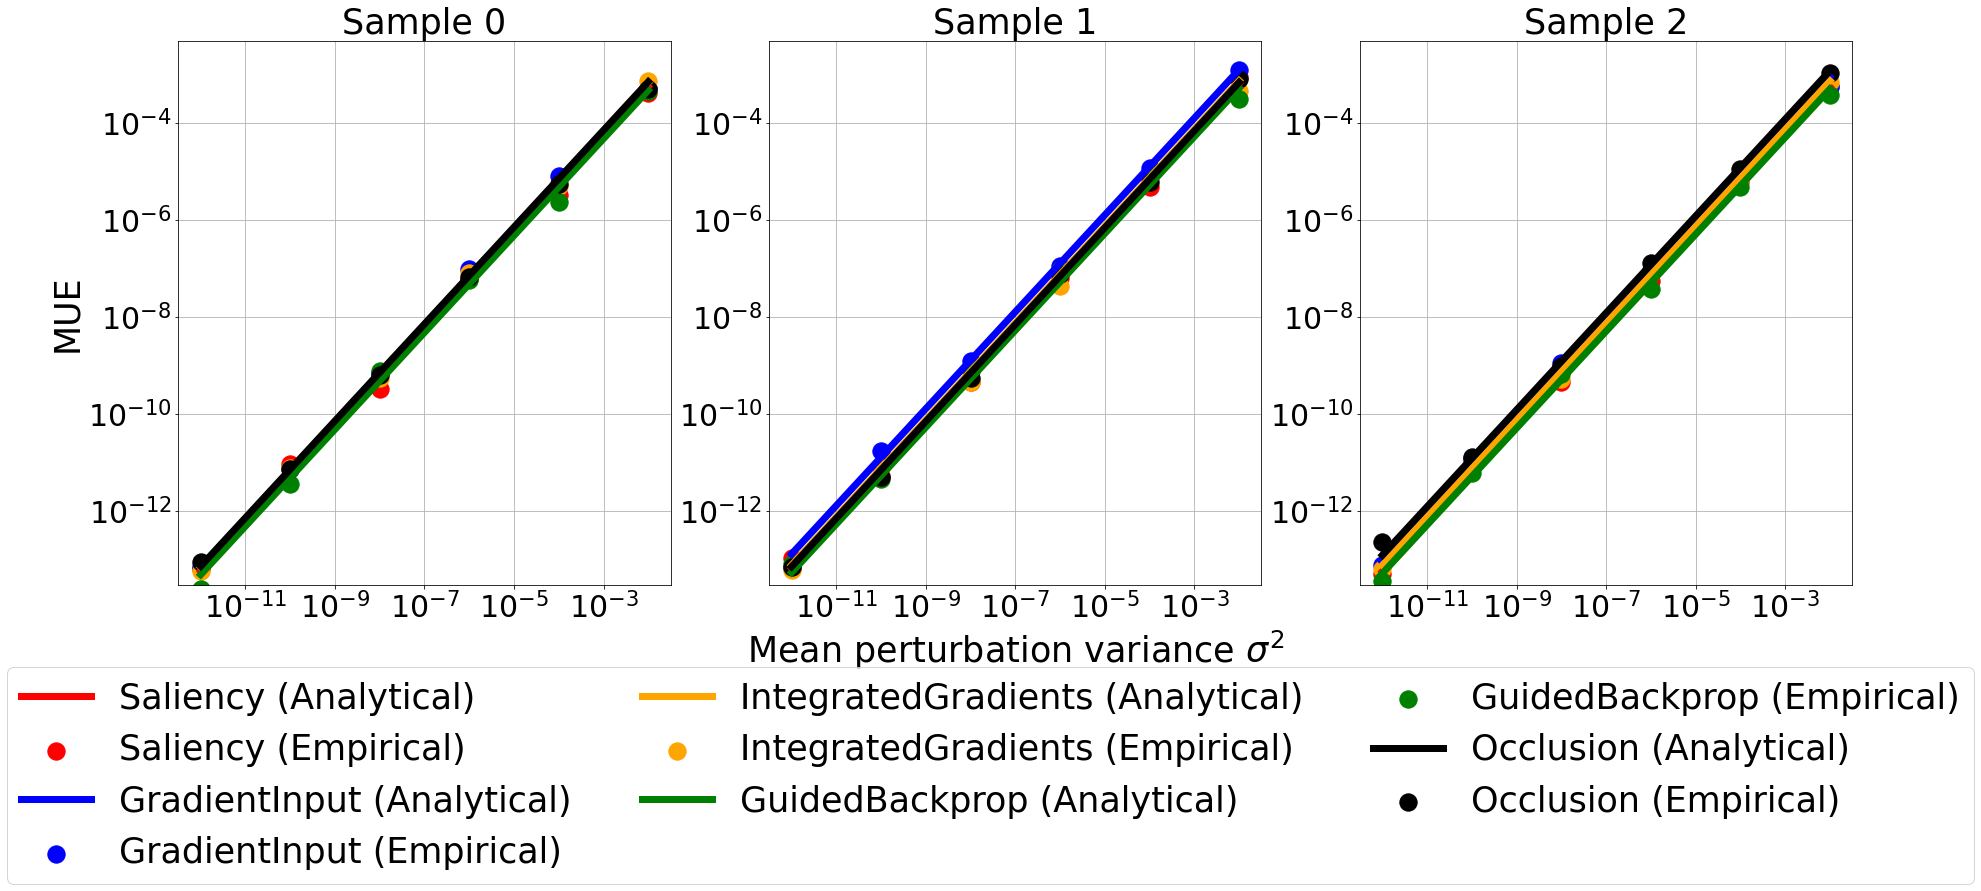

In [34]:
# Plot seveeral samples
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fsize=35
fig = plt.figure(figsize=(30, 10))
for i, sample_id in enumerate([0, 1, 2]): 
    plt.subplot(1, 3, i+1)
    for (name, data), col in zip(experiments['results'][sample_id].items(), colors):
        plt.plot(stds*stds, np.asarray(data['analytical'])[:len(stds)]/m, label=f"{name} (Analytical)", c=col, lw=7)
        plt.scatter(stds*stds, np.asarray(data['empirical'])[:len(stds)]/m, marker='o', 
                    label=f"{name} (Empirical)", c=col, s=300)
    plt.title('Sample ' + str(sample_id), fontsize=fsize)
    if i==1: plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
    if i==0: plt.ylabel('MUE', fontsize=fsize)
    plt.xscale('log');plt.yscale('log')
    plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
    plt.ylim([3e-14, 5e-3])
    if i==2: plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.75, -0.12), ncol=3)
    plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_weights_tabular.png', bbox_inches='tight')

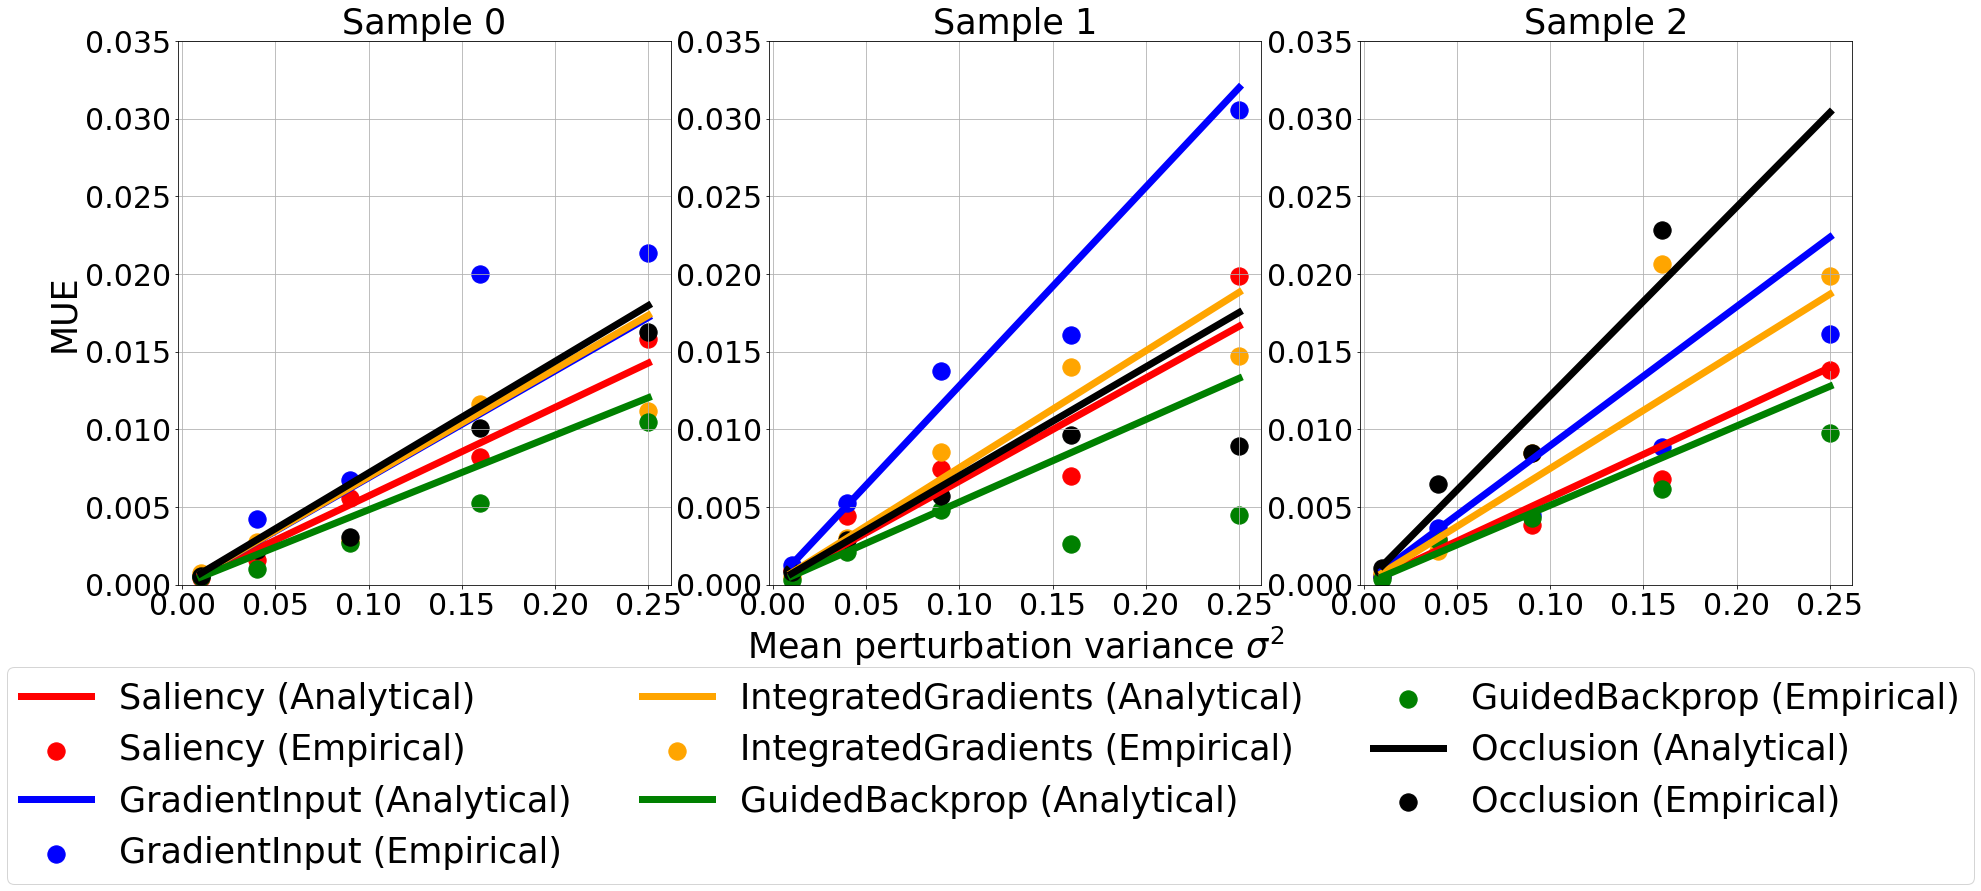

In [25]:
# Plot seveeral samples
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])
fsize=35
fig = plt.figure(figsize=(30, 10))
for i, sample_id in enumerate([0, 1, 2]): 
    plt.subplot(1, 3, i+1)
    for (name, data), col in zip(experiments['results'][sample_id].items(), colors):
        plt.plot(stds*stds, np.asarray(data['analytical'])[-len(stds):]/m, label=f"{name} (Analytical)", c=col, lw=7)
        plt.scatter(stds*stds, np.asarray(data['empirical'])[-len(stds):]/m, marker='o', 
                    label=f"{name} (Empirical)", c=col, s=300)
    plt.title('Sample ' + str(sample_id), fontsize=fsize)
    if i==1: plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
    if i==0: plt.ylabel('MUE', fontsize=fsize)
    #plt.xscale('log');plt.yscale('log')
    plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
    plt.ylim([0.0, 0.035])
    if i==2: plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.75, -0.12), ncol=3)
    plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_weights_tabular_extended.png', bbox_inches='tight')

In [26]:
# Aggregate results
agg_results = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5])
sample_indexes = np.arange(10)
for name in xai_methods.keys():
    for approach in ['analytical', 'empirical']:
        agg_sum = np.zeros(len(stds))
        for ex_ind in sample_indexes:
            sample_res = experiments['results'][ex_ind][name][approach]
            if np.isnan(sample_res).any():
                sample_res = np.finfo(float).eps * np.ones(len(stds))
            agg_sum += sample_res
        agg_results[name][approach] = agg_sum/len(sample_indexes)
#agg_results

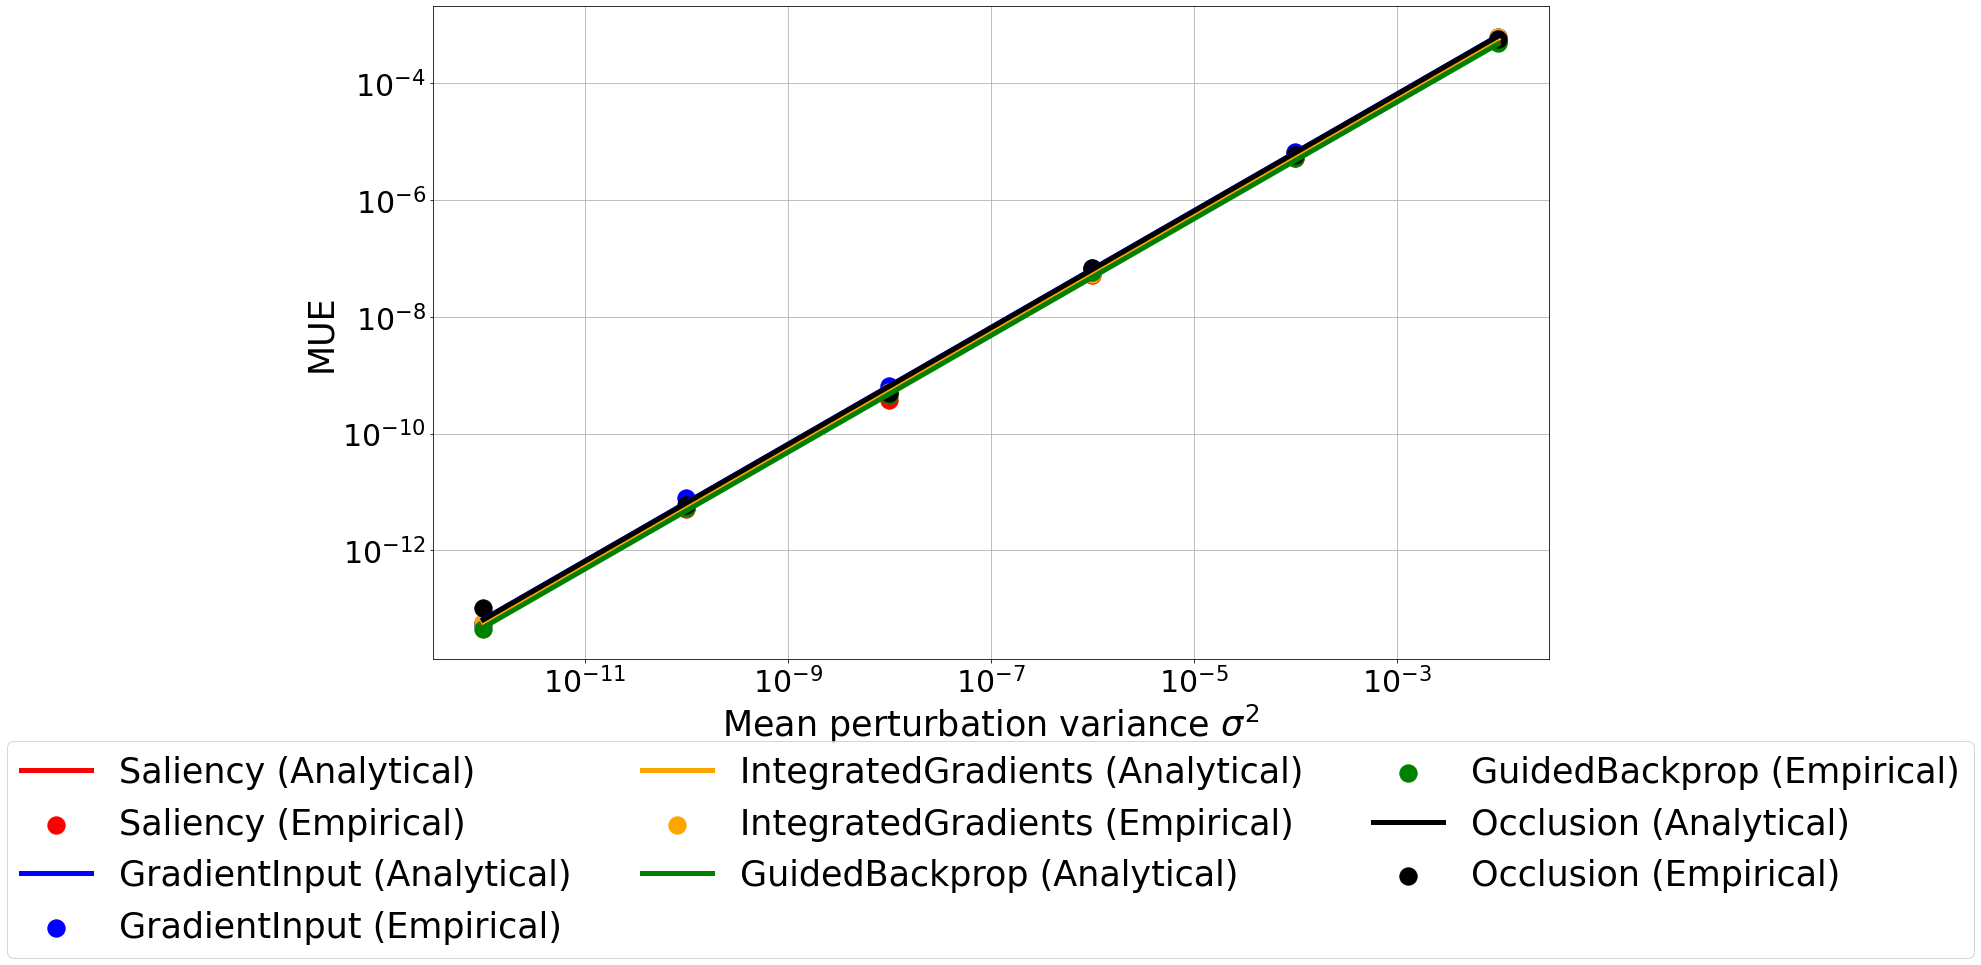

In [28]:
# Plot aggregations
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fsize=35
fig = plt.figure(figsize=(20, 12))
for (name, data), col in zip(agg_results.items(), colors):
    plt.plot(stds*stds, np.asarray(data['analytical'])[:len(stds)]/m, label=f"{name} (Analytical)", c=col, lw=5)
    plt.scatter(stds*stds, np.asarray(data['empirical'])[:len(stds)]/m,  marker='o', 
                label=f"{name} (Empirical)", c=col, s=300)
plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
plt.ylabel('MUE', fontsize=fsize)
plt.xscale('log');plt.yscale('log')
plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           ncol=3)
plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_weights_tabular_agg.png', bbox_inches='tight')

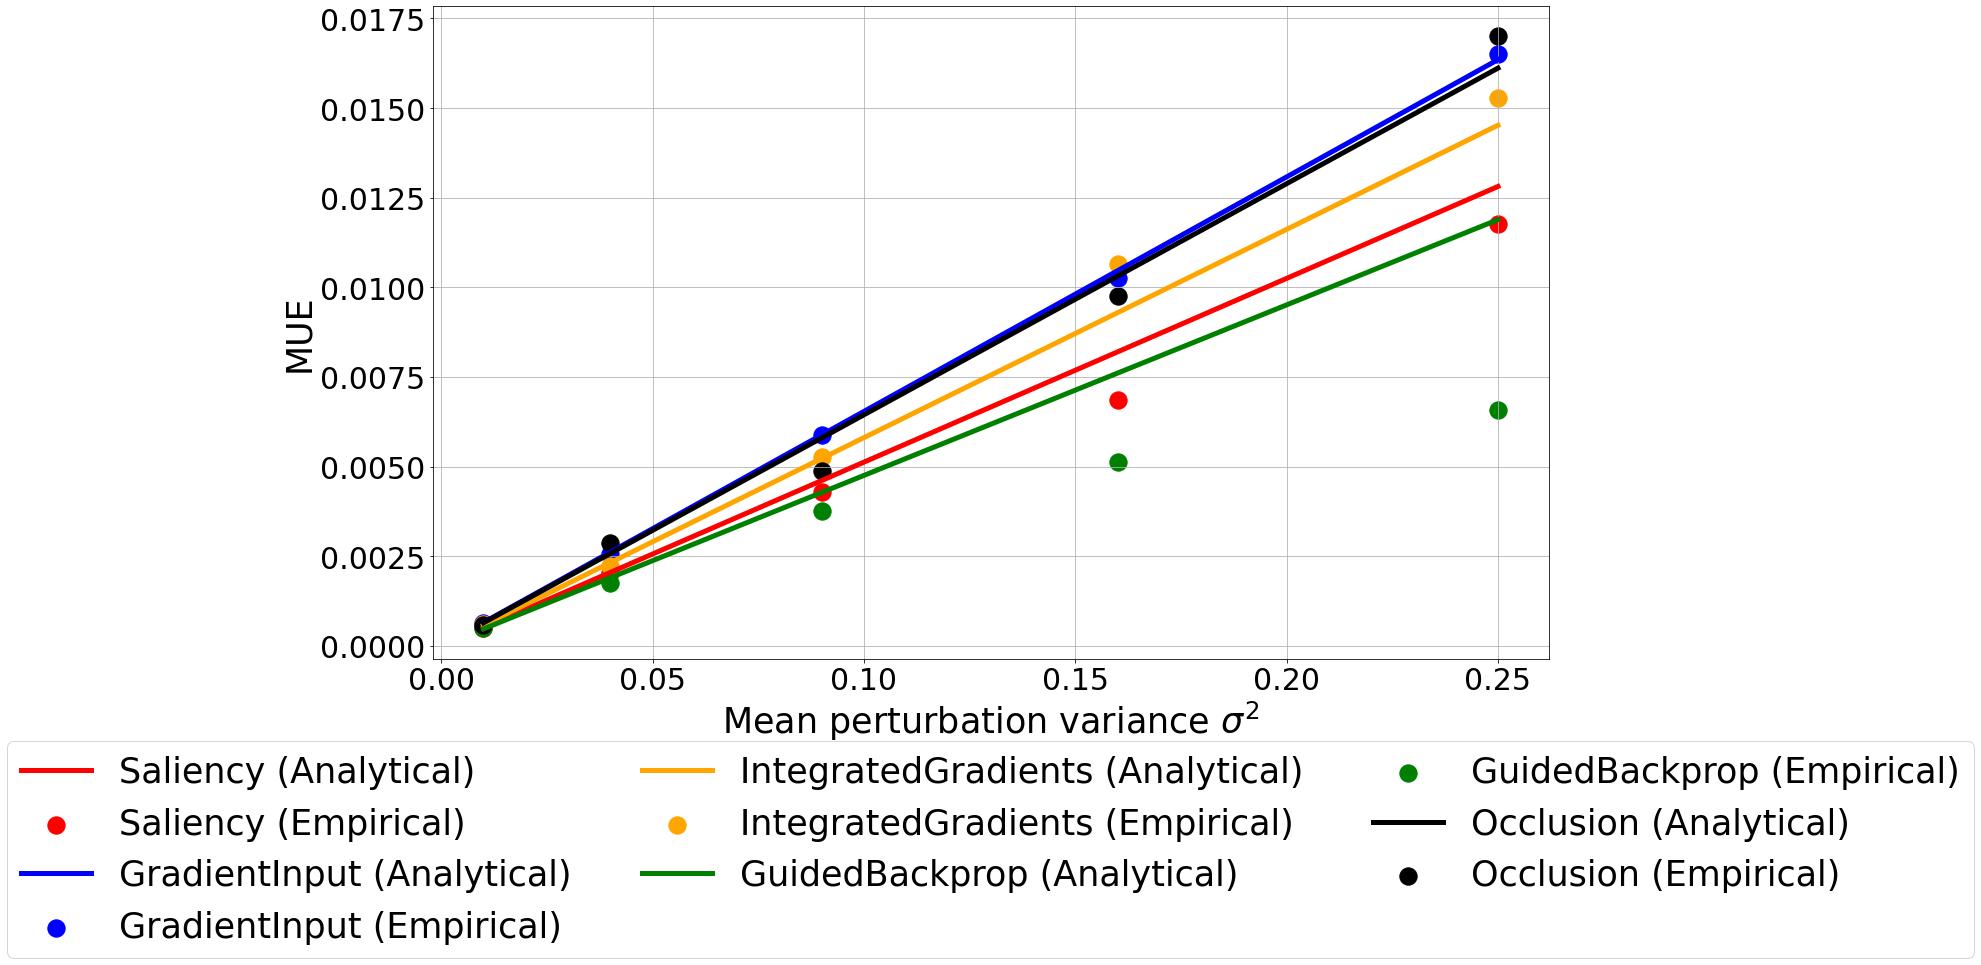

In [29]:
# Plot aggregations
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])
fsize=35
fig = plt.figure(figsize=(20, 12))
for (name, data), col in zip(agg_results.items(), colors):
    plt.plot(stds*stds, np.asarray(data['analytical'])[-len(stds):]/m, label=f"{name} (Analytical)", c=col, lw=5)
    plt.scatter(stds*stds, np.asarray(data['empirical'])[-len(stds):]/m,  marker='o', 
                label=f"{name} (Empirical)", c=col, s=300)
plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
plt.ylabel('MUE', fontsize=fsize)
#plt.xscale('log');plt.yscale('log')
plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           ncol=3)
plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_weights_tabular_agg_extended.png', bbox_inches='tight')

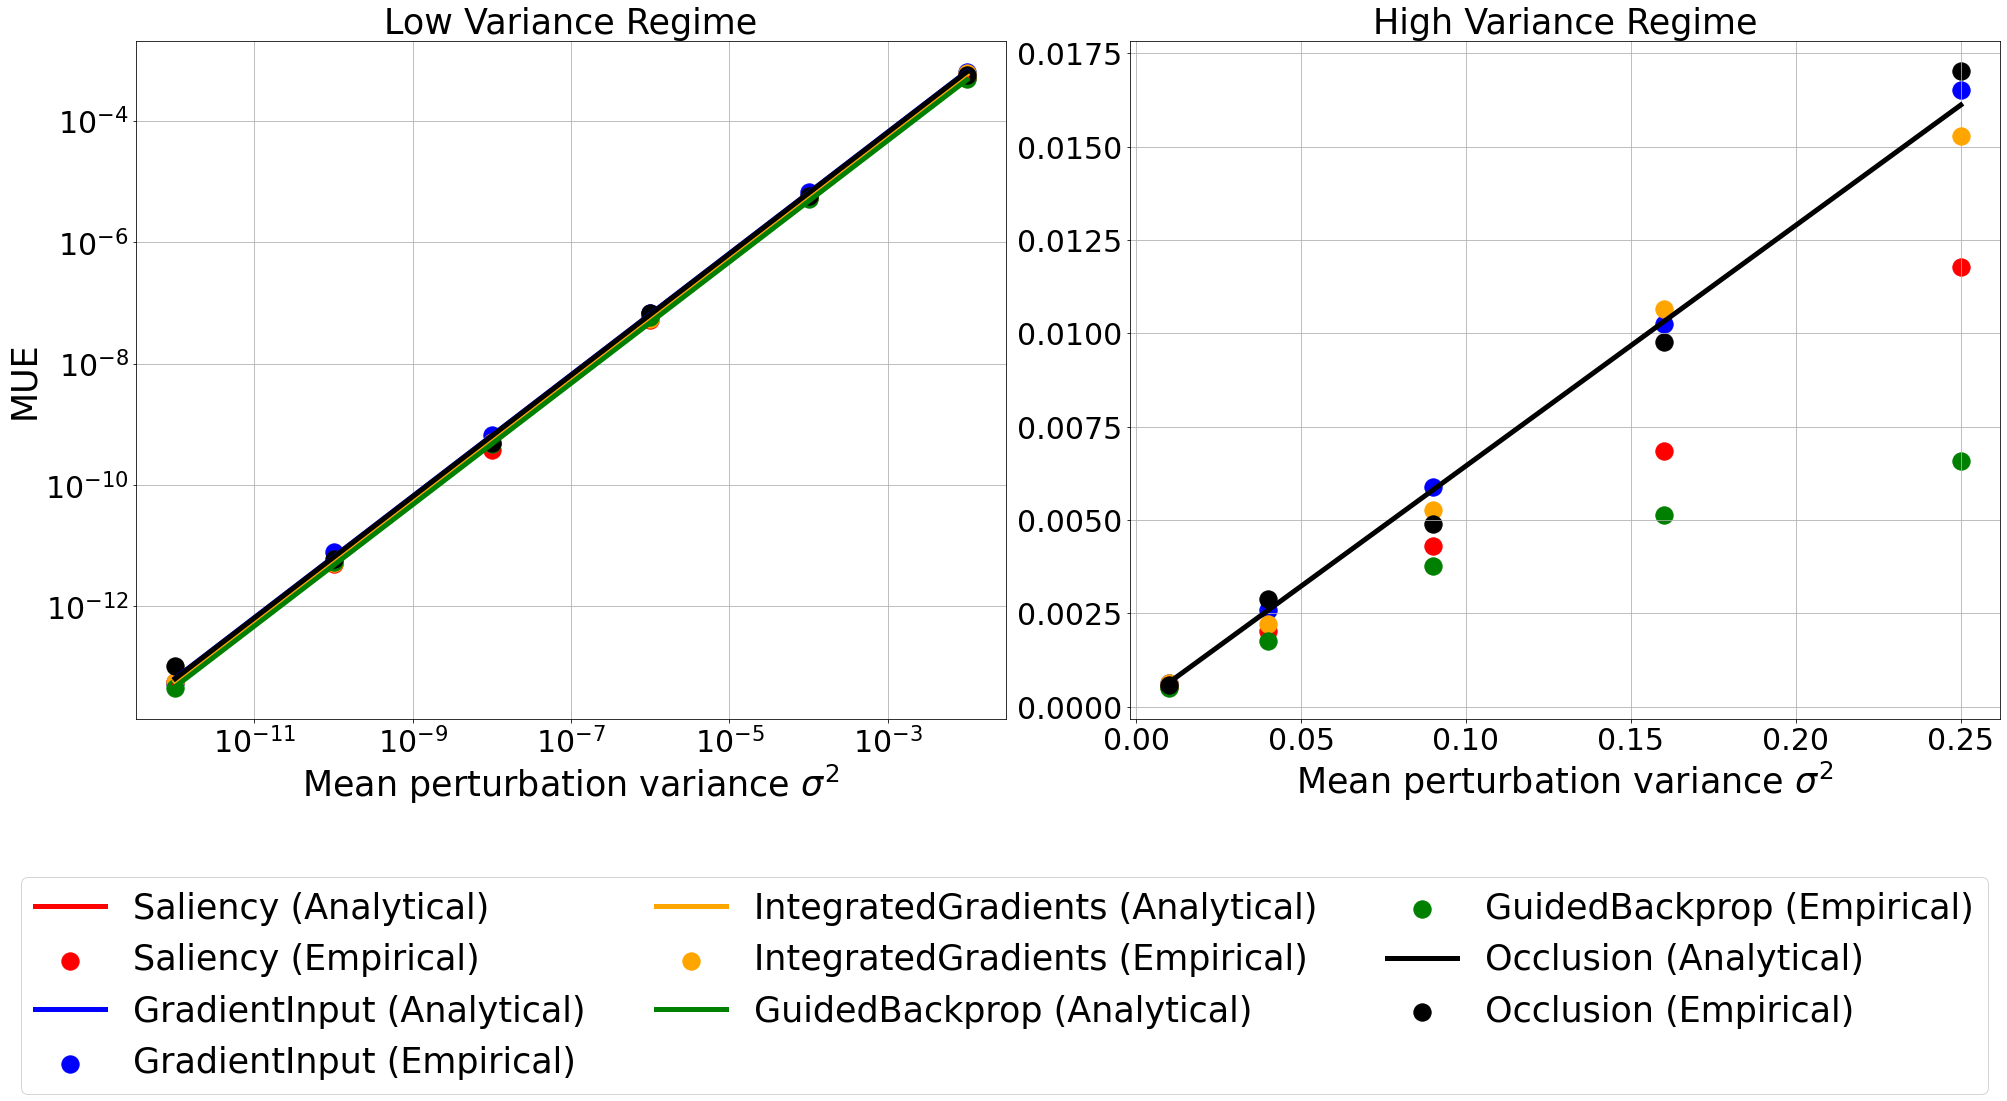

In [31]:
# Define parameters
colors = ['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
fsize = 35

# Define standard deviations for both plots
stds1 = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
stds2 = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))#, sharey=True)

# Plot first subplot
ax = axes[0]
for (name, data), col in zip(agg_results.items(), colors):
    ax.plot(stds1 * stds1, np.asarray(data['analytical'])[:len(stds1)] / m, label=f"{name} (Analytical)", c=col, lw=5)
    ax.scatter(stds1 * stds1, np.asarray(data['empirical'])[:len(stds1)] / m, marker='o', label=f"{name} (Empirical)", c=col, s=300)
ax.set_xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
ax.set_ylabel('MUE', fontsize=fsize)
ax.set_xscale('log');ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=fsize-5)
ax.grid(True)
ax.set_title("Low Variance Regime", fontsize=fsize)

# Plot second subplot
ax = axes[1]
for (name, data), col in zip(agg_results.items(), colors):
    if name == 'Occlusion':
        ax.plot(stds2 * stds2, np.asarray(data['analytical'])[-len(stds2):] / m, label=f"{name} (Analytical)", c=col, lw=5)
    ax.scatter(stds2 * stds2, np.asarray(data['empirical'])[-len(stds2):] / m, marker='o', label=f"{name} (Empirical)", c=col, s=300)
ax.set_xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=fsize-5)
ax.grid(True)
ax.set_title("High Variance Regime", fontsize=fsize)

# Create a single legend below both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=3)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
fig.savefig('./figures/uncertainties_weights_tabular_agg_combi.png', bbox_inches='tight')

C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


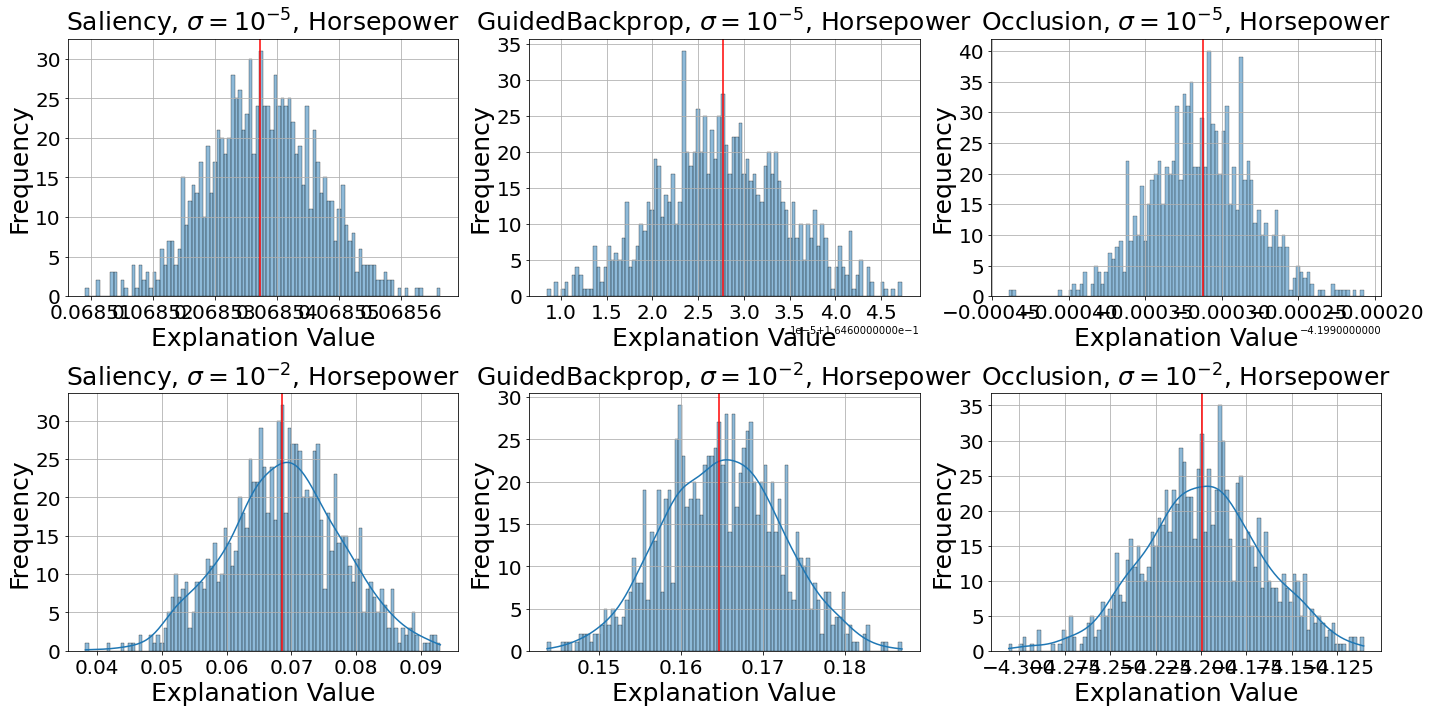

In [19]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 2
fsize = 25
fig = plt.figure(figsize=(20, 10))
#fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(['Saliency', 'GuidedBackprop', 'Occlusion']): 
    for j, std in enumerate([1e-5, 1e-2]):
        plt.subplot(2,3,3*j+i+1)
        sns.histplot(experiments['empirical_exps'][sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=experiments['unperturbed_exps'][sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ', $\sigma=10^{' + str(int(np.log10(std))) + '}$, ' + features_name[feature_id], fontsize=fsize)
        #if i == 0: plt.xlim([4.2, 5.2])
        #elif i == 1: plt.xlim([-0.05, 0.2])
        #elif i == 2 and j == 0: plt.xlim([-0.0001, 0.0001]);plt.xticks([-1e-4, 0.0, 1e-4])
        #elif i == 2 and j == 1: plt.xlim([-0.03, 0.08])
        plt.xlabel("Explanation Value", fontsize=fsize); plt.xticks(fontsize=fsize-5)
        plt.ylabel("Frequency", fontsize=fsize); plt.yticks(fontsize=fsize-5)
        plt.grid()
plt.tight_layout()
#fig.savefig('./figures/weights_tabular_normality.png', bbox_inches='tight')
plt.show()

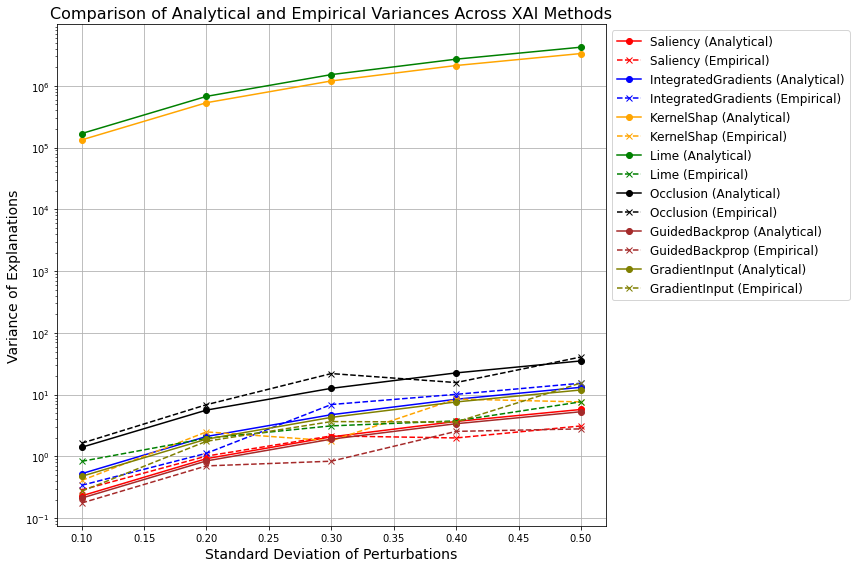

In [20]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14)
plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14)
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

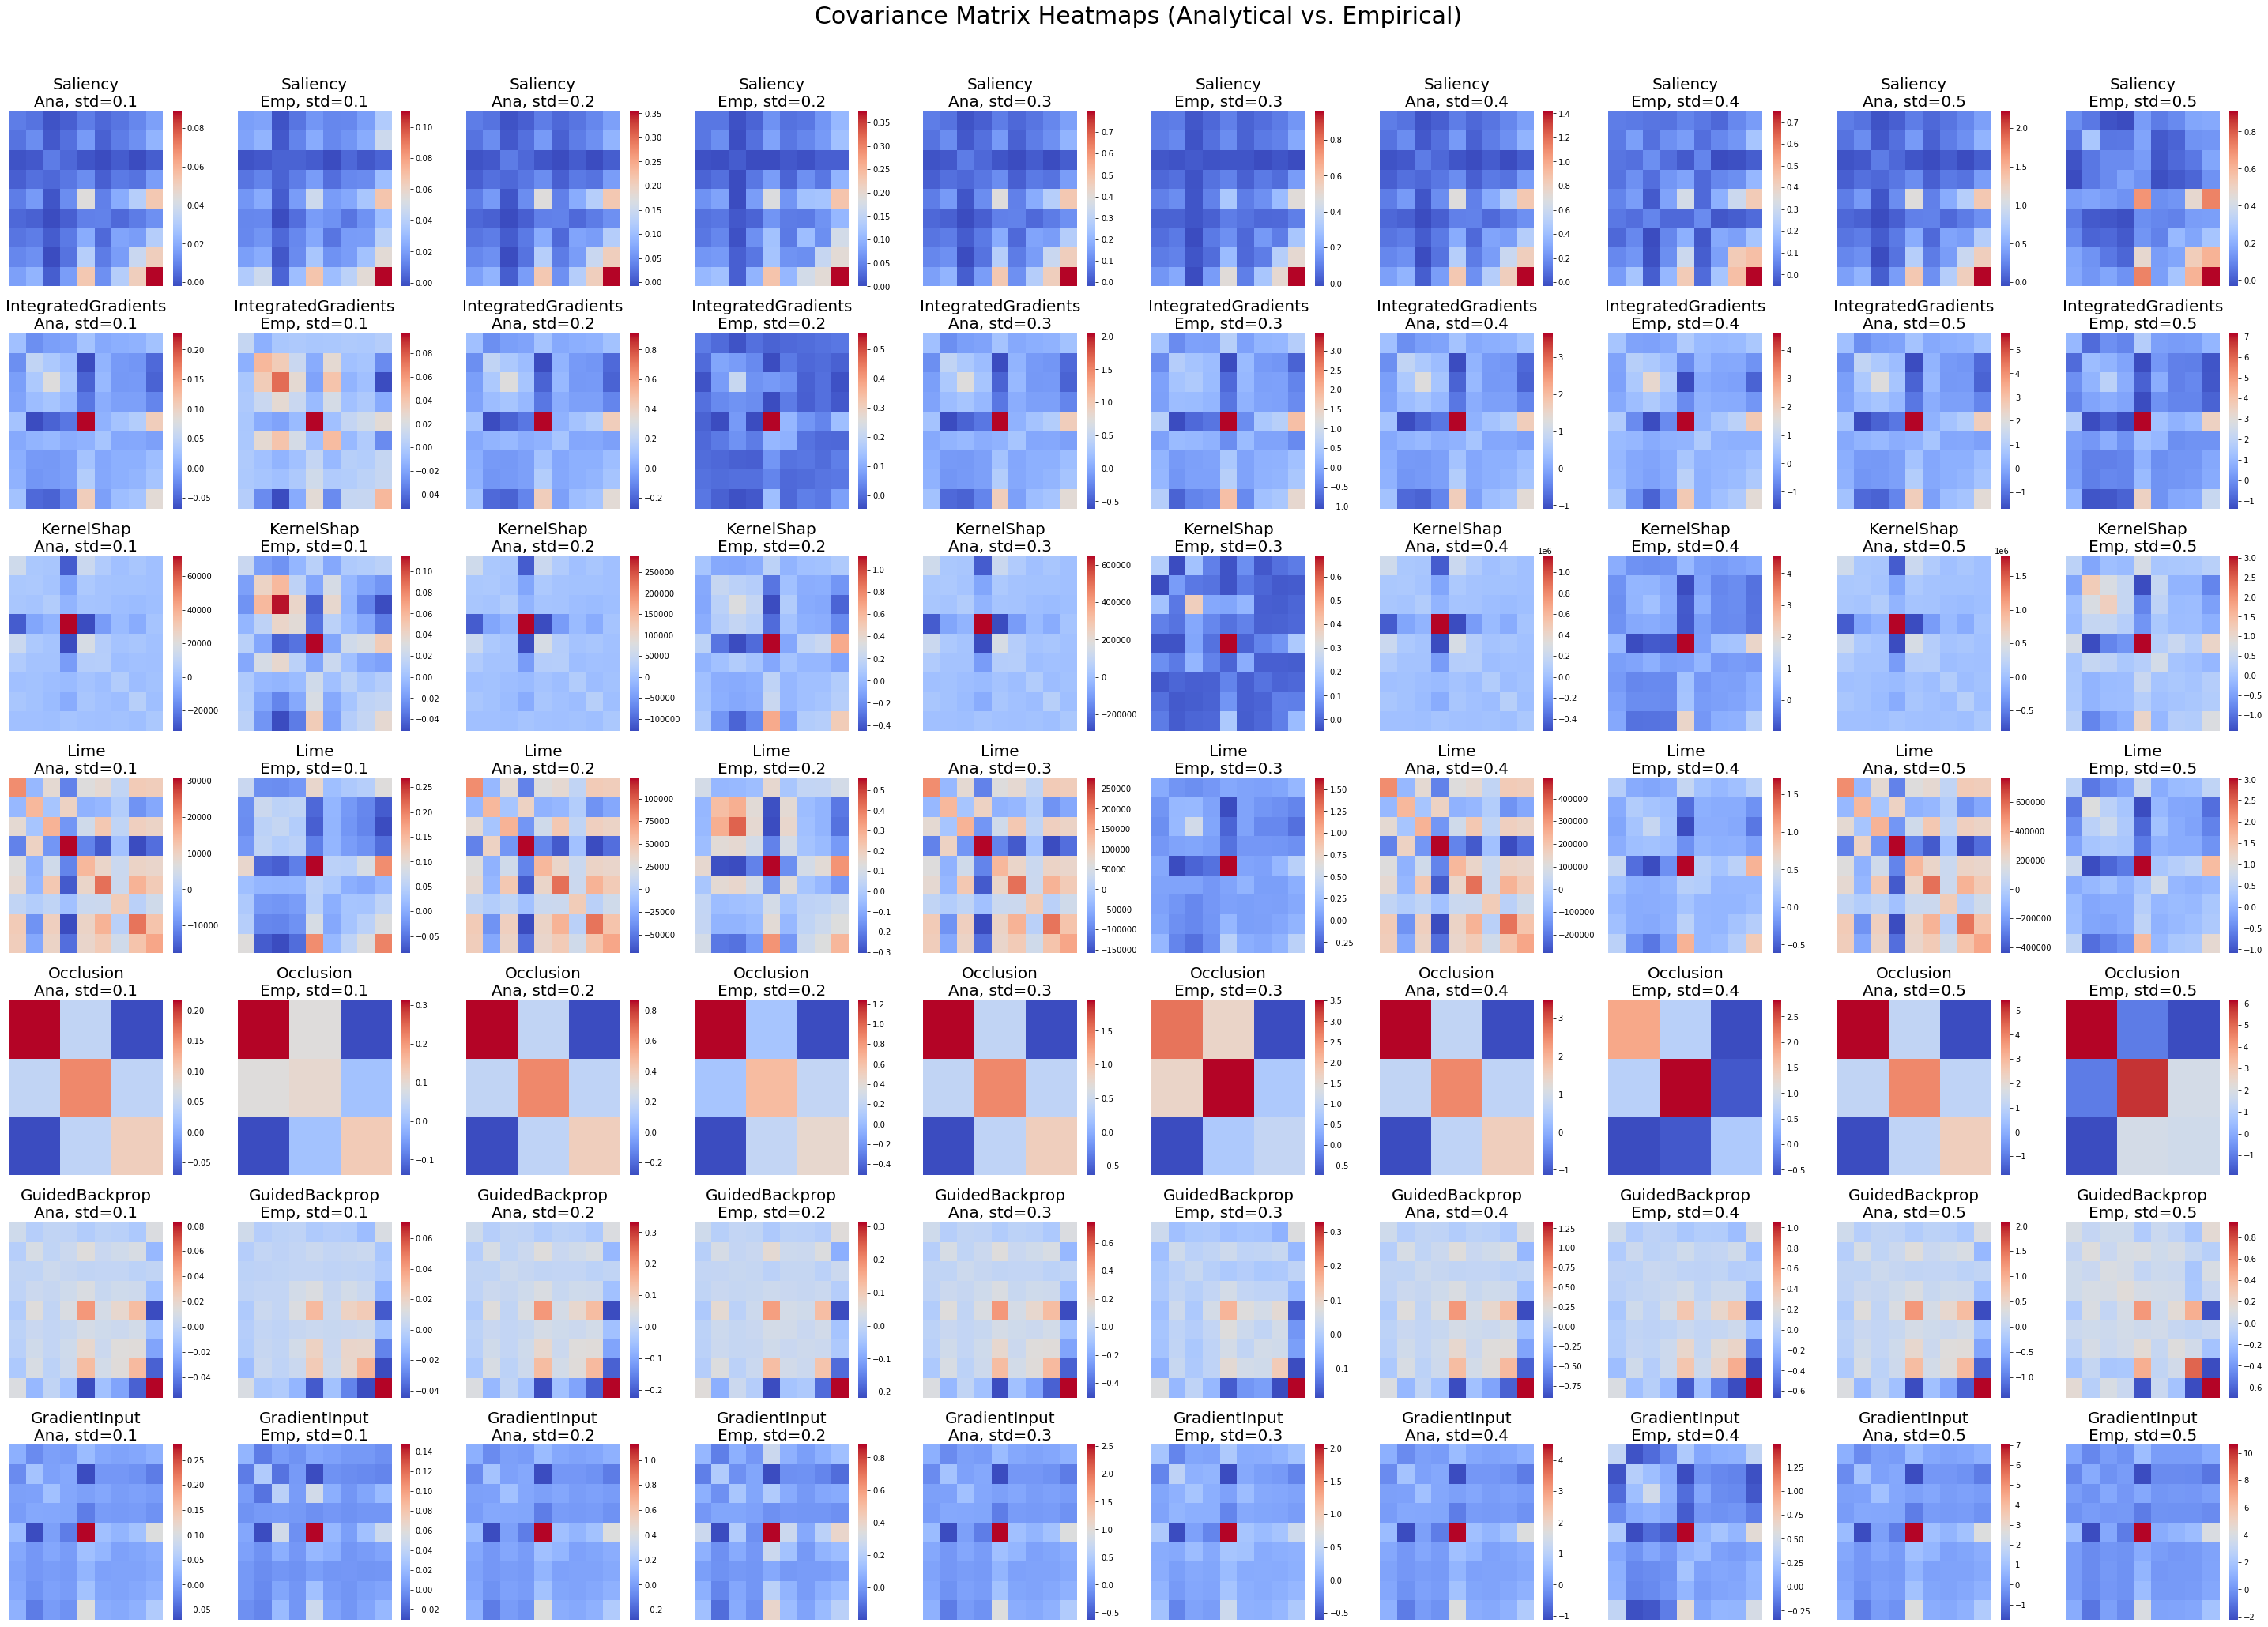

In [21]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 2 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)

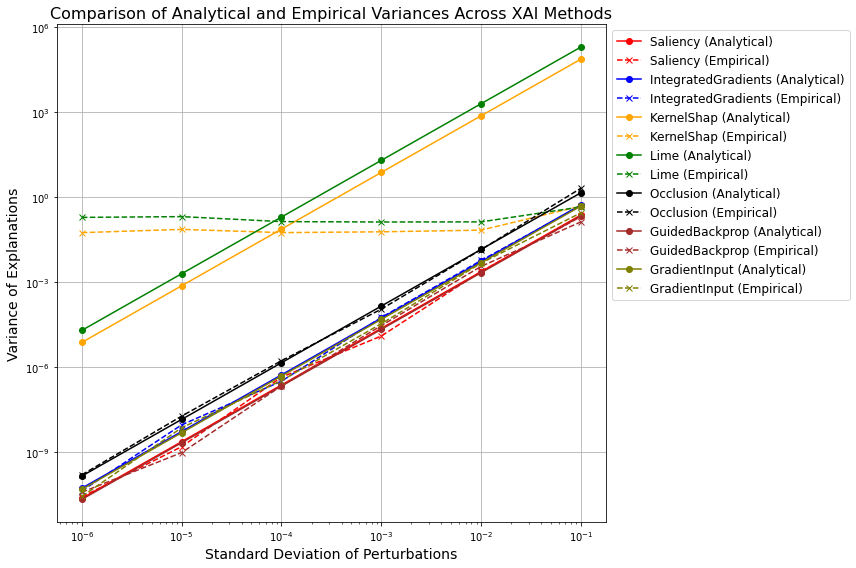

In [18]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14);plt.xscale('log')
plt.ylabel('Variance of Explanations', fontsize=14);plt.yscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()